In [1]:
%pip install catboost mne colorlog

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 43.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 130.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 116.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


# Functional preperation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import utils
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, CatBoostRegressor

logger = utils.get_logger()

In [2]:
# test catboost
dataset = np.array([[1,4,5,6],[4,5,6,7],[30,40,50,60],[20,15,85,60]])
train_labels = [1.2,3.4,9.5,24.5]
model = CatBoostRegressor(learning_rate=1, depth=6, loss_function='RMSE')
fit_model = model.fit(dataset, train_labels)

print(fit_model.get_params())

0:	learn: 6.8953900	total: 46.1ms	remaining: 46.1s
1:	learn: 4.8590818	total: 46.8ms	remaining: 23.3s
2:	learn: 3.6271477	total: 46.9ms	remaining: 15.6s
3:	learn: 2.7203608	total: 47.1ms	remaining: 11.7s
4:	learn: 2.0402706	total: 47.4ms	remaining: 9.43s
5:	learn: 1.5302029	total: 47.6ms	remaining: 7.89s
6:	learn: 1.1476522	total: 47.8ms	remaining: 6.79s
7:	learn: 0.8607391	total: 48.1ms	remaining: 5.96s
8:	learn: 0.6455544	total: 48.3ms	remaining: 5.32s
9:	learn: 0.4841658	total: 48.5ms	remaining: 4.8s
10:	learn: 0.3631243	total: 48.7ms	remaining: 4.38s
11:	learn: 0.2723432	total: 49ms	remaining: 4.03s
12:	learn: 0.2042574	total: 49.2ms	remaining: 3.73s
13:	learn: 0.1531931	total: 49.4ms	remaining: 3.48s
14:	learn: 0.1148948	total: 49.6ms	remaining: 3.26s
15:	learn: 0.0861711	total: 49.9ms	remaining: 3.07s
16:	learn: 0.0646283	total: 50.1ms	remaining: 2.9s
17:	learn: 0.0484712	total: 50.3ms	remaining: 2.75s
18:	learn: 0.0363534	total: 50.5ms	remaining: 2.61s
19:	learn: 0.0272651	total

TBB Warning: The number of workers is currently limited to 3. The request for 47 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



In [3]:
labels_df = utils.get_metadata_df("features-4", "Randomisatielijst.csv")
labels_df

,filename,procedure,patient_id,eeg_type,pre_post
0,TMS-EEG-H_07_S3_rsEEG_pre-epo.csv,itbs,07,rsEEG,pre
1,TMS-EEG-H_06_S2_rsEEG_pre-epo.csv,itbs,06,rsEEG,pre
2,TMS-EEG-H_14_S1_rsEEG_pre-epo.csv,ctbs,14,rsEEG,pre
3,TMS-EEG-H_17_S2_rsEEG_pre-epo.csv,sham,17,rsEEG,pre
4,TMS-EEG-H_16_S3_rsEEG_pre-epo.csv,itbs,16,rsEEG,pre
...,...,...,...,...,...
83,TMS-EEG-H_02_S3_rsEEG_pre-epo.csv,ctbs,02,rsEEG,pre
84,TMS-EEG-H_09_S3_rsEEG_post-epo.csv,sham,09,rsEEG,post
85,TMS-EEG-H_08_s1_rsEEG_pre-epo.csv,sham,08,rsEEG,pre
86,TMS-EEG-H_16_S2_rsEEG_post-epo.csv,sham,16,rsEEG,post


In [4]:
# Create train-test split using feature files
train_filenames, test_filenames = utils.get_train_test_split("features-4", random_state=0)
print(f"Train files: {len(train_filenames)}; Test files: {len(test_filenames)}")

Train files: 71; Test files: 17


In [5]:
def get_data(directory, filenames):
    """Returns a df containing all rows from the given feature files."""
    data = []
    for filename in filenames:
        df = pd.read_csv(os.path.join(directory, filename), header=[0,1])
        data.append(df)
    df = pd.concat(data)
    return df

def get_labels(label_name, label_df, filenames):
    """Returns a df column containg the labels for the given filenames. This is achieved by repeating the respective label for each row in the feature file."""
    labels = []
    for filename in filenames:
        df = pd.read_csv(os.path.join("features-4", filename), header=[0,1])
        rows = df.shape[0]
        label = label_df[label_df['filename'] == filename][label_name].values[0]
        # add label * rows times
        labels.extend([label] * rows)
    df = pd.DataFrame(labels, columns=[label_name])
    return df

In [6]:
def data_prep(train_data_df, train_labels_df, test_data_df, outlier_threshold = 0.05):
    """Standardizes and removes outliers in data."""
    def remove_outliers_zscore(df, threshold=3):
        z_scores = np.abs(zscore(df))
        return df[(z_scores < threshold).all(axis=1)]
    
    # Standardization
    scaler = StandardScaler()
    train_data_df = pd.DataFrame(scaler.fit_transform(train_data_df), columns=train_data_df.columns)
    test_data_df = pd.DataFrame(scaler.fit_transform(test_data_df), columns=test_data_df.columns)
    
    # Outlier removal
    Q1 = train_data_df.quantile(0.10)
    Q3 = train_data_df.quantile(0.90)
    IQR = Q3 - Q1

    def is_outlier(row):
        return ((row < (Q1 - 1.5 * IQR)) | (row > (Q3 + 1.5 * IQR))).sum()

    outlier_counts = train_data_df.apply(is_outlier, axis=1)
    threshold = len(train_data_df.columns) * outlier_threshold
    rows_to_drop = outlier_counts[outlier_counts > threshold].index
    train_data_df_filtered = train_data_df.drop(index=rows_to_drop)
    train_labels_df = train_labels_df.drop(index=rows_to_drop)
    print(f"Original DataFrame shape: {train_data_df.shape}")
    print(f"Filtered DataFrame shape: {train_data_df_filtered.shape}")
    train_data_df = train_data_df_filtered

    return train_data_df, train_labels_df, test_data_df

In [7]:
def train_catboost(train_data, train_labels, test_data, test_labels, loss_function="Logloss"):
    test_data = catboost_pool = Pool(test_data,
                                     test_labels)
    
    model = CatBoostClassifier(iterations=50,
                               depth=3,
                               learning_rate=0.3,
                               loss_function=loss_function,
                               verbose=False)
    # train the model
    model.fit(train_data, train_labels)

    # make test predictions using the resulting model
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    
    accuracy = accuracy_score(test_labels_df, preds_class)
    print("Accuracy on test set: ", accuracy)
    
    return model

## Individual model training

Train one model for two paradigms:

1. **pre/post classification**: for a given procedure of a given patient, classify into pre or post procedure
2. **procedure classification**: for a given procedure, classifiy which procedure it was

Train test split is solely from within the patient.

[2024-07-19 17:38:53,750] - INFO - Training model for patient 07 and procedure sham


Original DataFrame shape: (337, 6913)
Filtered DataFrame shape: (337, 6913)
Accuracy on test set:  0.9882352941176471


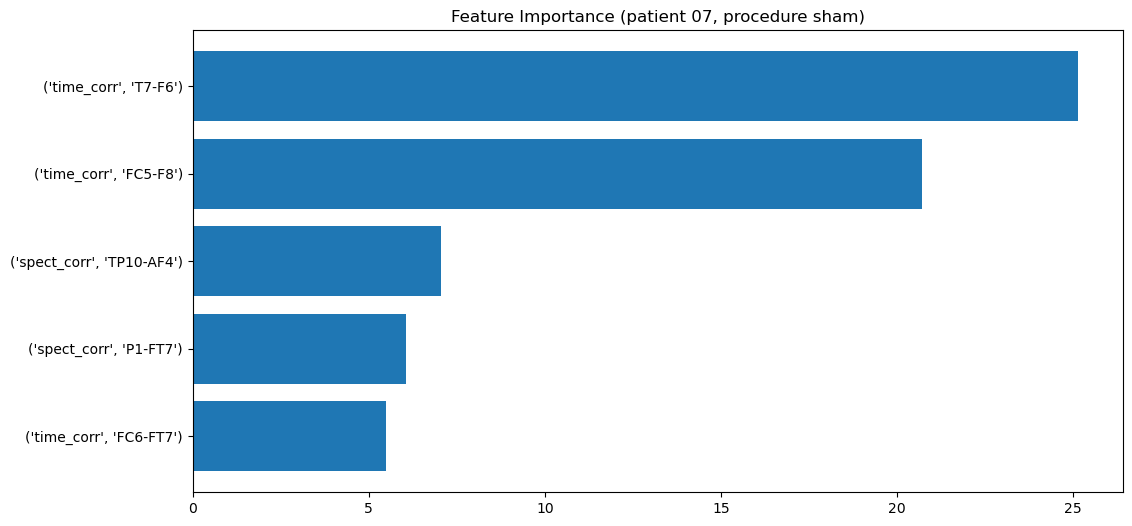

[2024-07-19 17:39:04,335] - INFO - Training model for patient 07 and procedure itbs


Original DataFrame shape: (336, 6913)
Filtered DataFrame shape: (336, 6913)
Accuracy on test set:  1.0


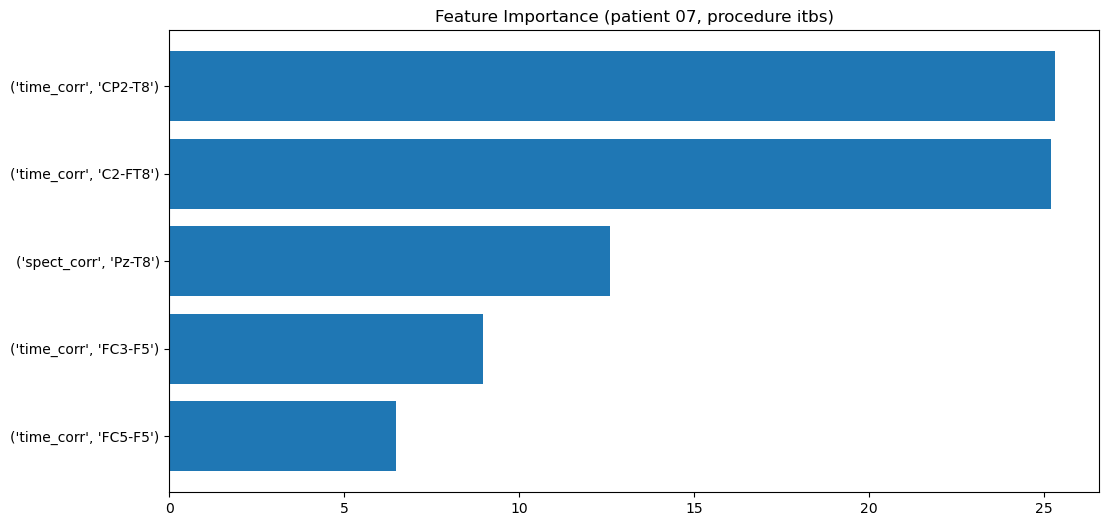

[2024-07-19 17:39:14,776] - INFO - Training model for patient 07 and procedure ctbs


Original DataFrame shape: (333, 6913)
Filtered DataFrame shape: (333, 6913)
Accuracy on test set:  1.0


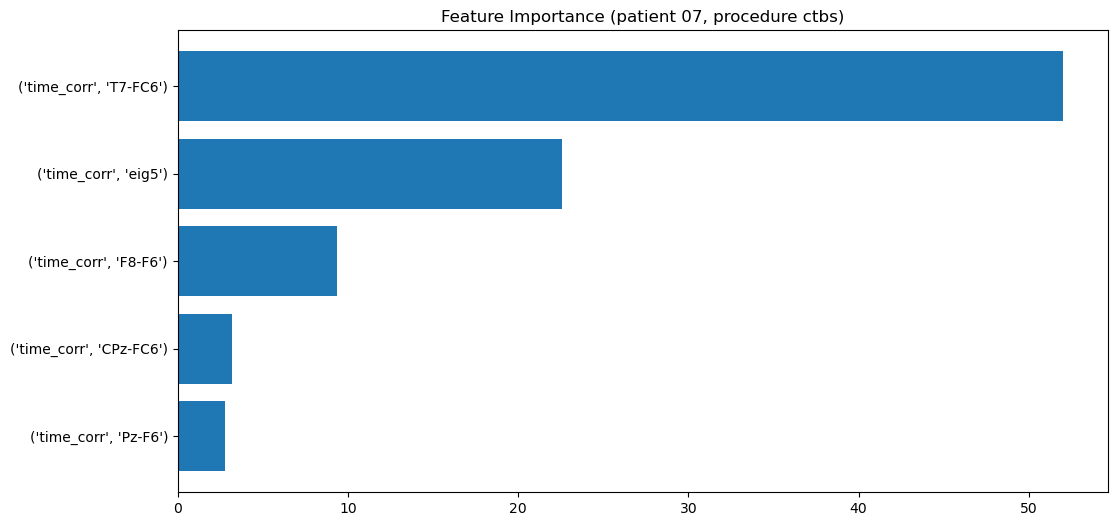

[2024-07-19 17:39:25,856] - INFO - Training model for patient 06 and procedure sham


Original DataFrame shape: (469, 6913)
Filtered DataFrame shape: (469, 6913)
Accuracy on test set:  0.9915254237288136


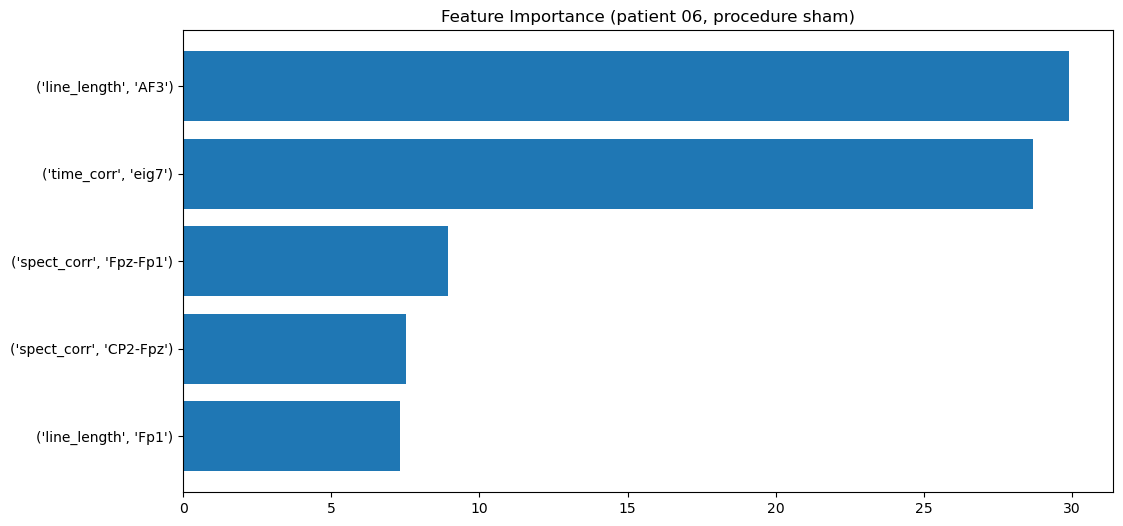

[2024-07-19 17:39:37,233] - INFO - Training model for patient 06 and procedure itbs


Original DataFrame shape: (511, 6913)
Filtered DataFrame shape: (511, 6913)
Accuracy on test set:  1.0


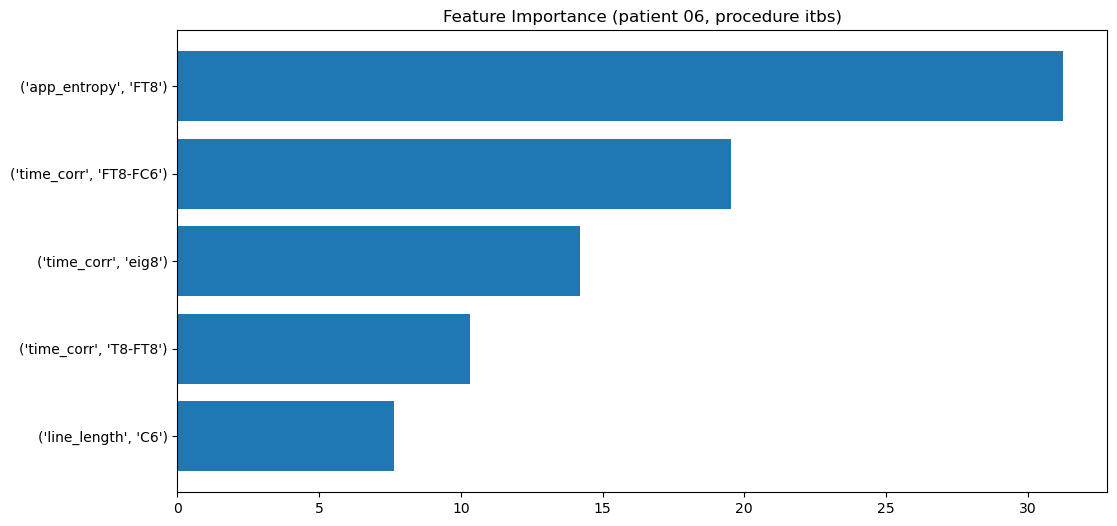

[2024-07-19 17:39:48,514] - INFO - Training model for patient 06 and procedure ctbs


Original DataFrame shape: (496, 6913)
Filtered DataFrame shape: (496, 6913)
Accuracy on test set:  1.0


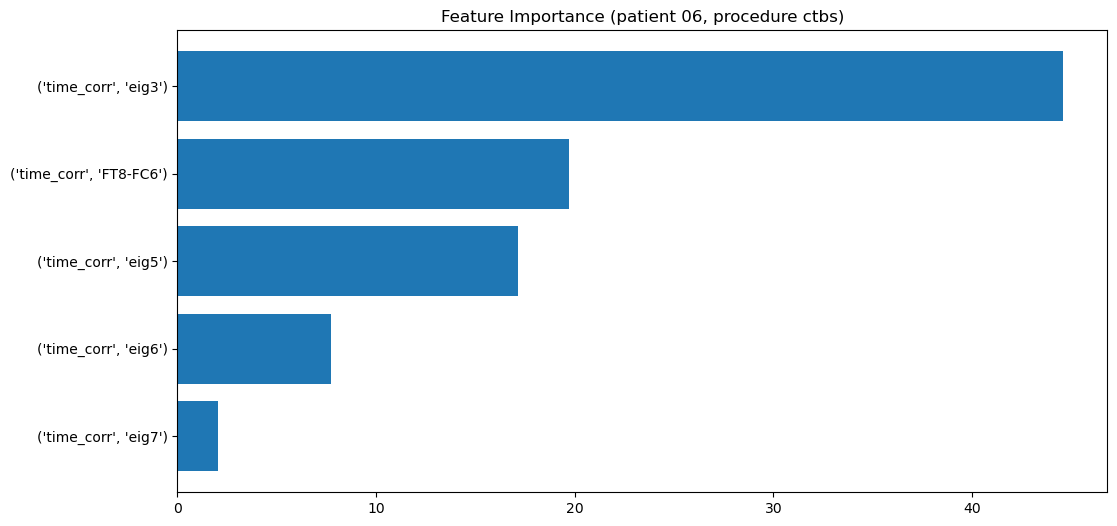

[2024-07-19 17:39:59,475] - INFO - Training model for patient 14 and procedure sham


Original DataFrame shape: (425, 6913)
Filtered DataFrame shape: (425, 6913)
Accuracy on test set:  0.9906542056074766


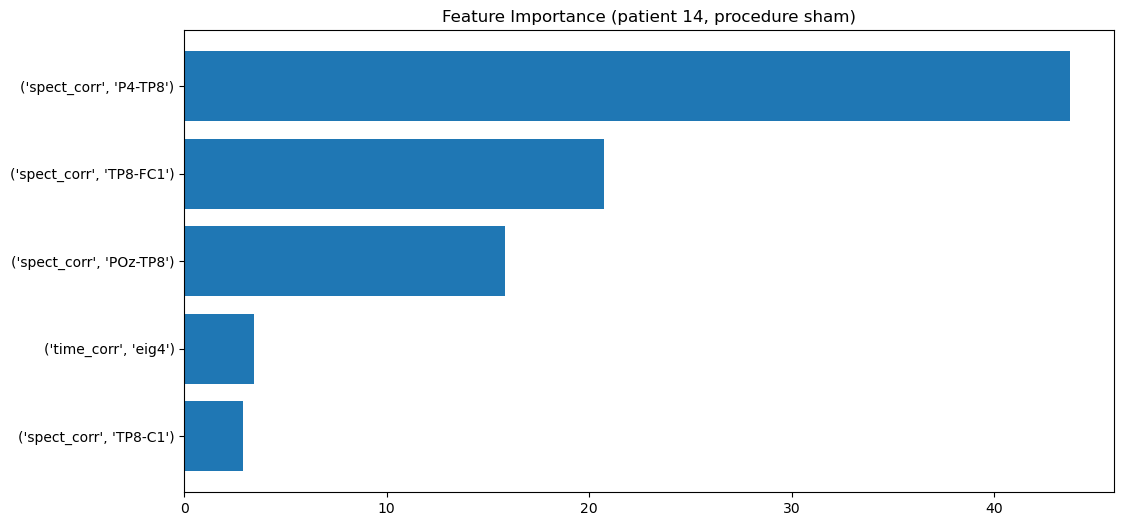

[2024-07-19 17:40:10,408] - INFO - Training model for patient 14 and procedure itbs


Original DataFrame shape: (439, 6913)
Filtered DataFrame shape: (439, 6913)
Accuracy on test set:  1.0


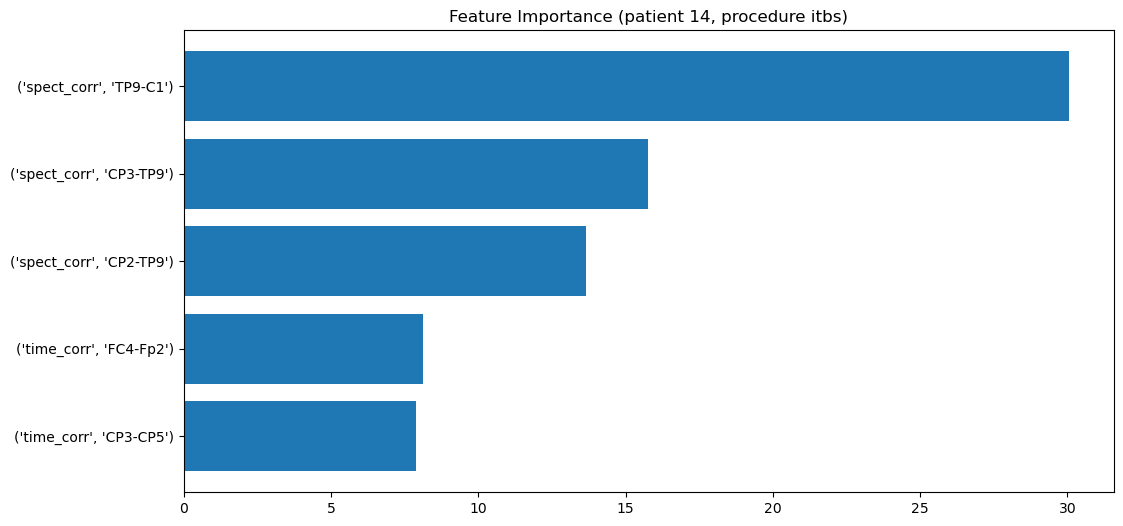

[2024-07-19 17:40:21,016] - INFO - Training model for patient 14 and procedure ctbs


Original DataFrame shape: (331, 6913)
Filtered DataFrame shape: (331, 6913)
Accuracy on test set:  1.0


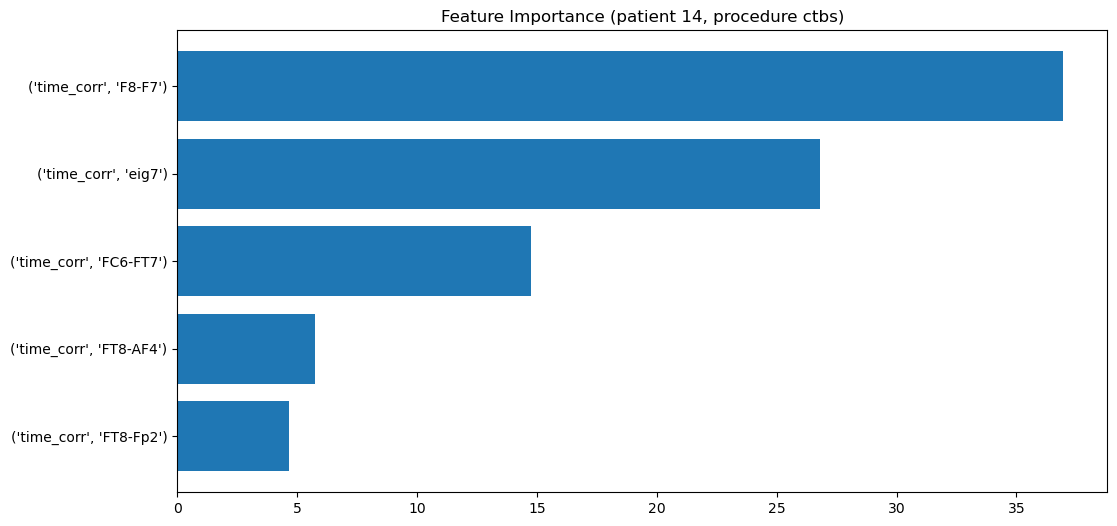

[2024-07-19 17:40:31,654] - INFO - Training model for patient 17 and procedure sham


Original DataFrame shape: (397, 6913)
Filtered DataFrame shape: (397, 6913)
Accuracy on test set:  1.0


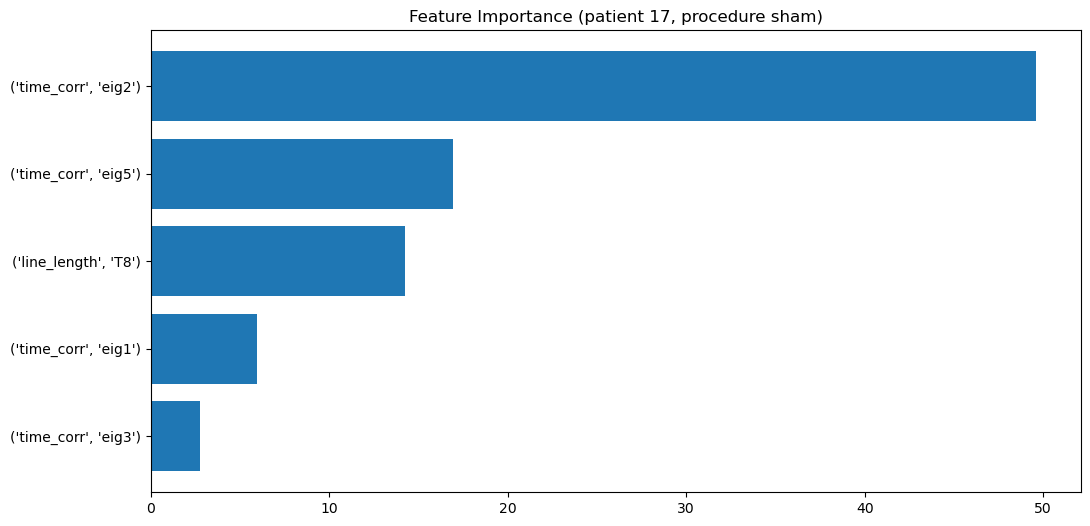

[2024-07-19 17:40:42,766] - INFO - Training model for patient 17 and procedure itbs


Original DataFrame shape: (446, 6913)
Filtered DataFrame shape: (446, 6913)
Accuracy on test set:  1.0


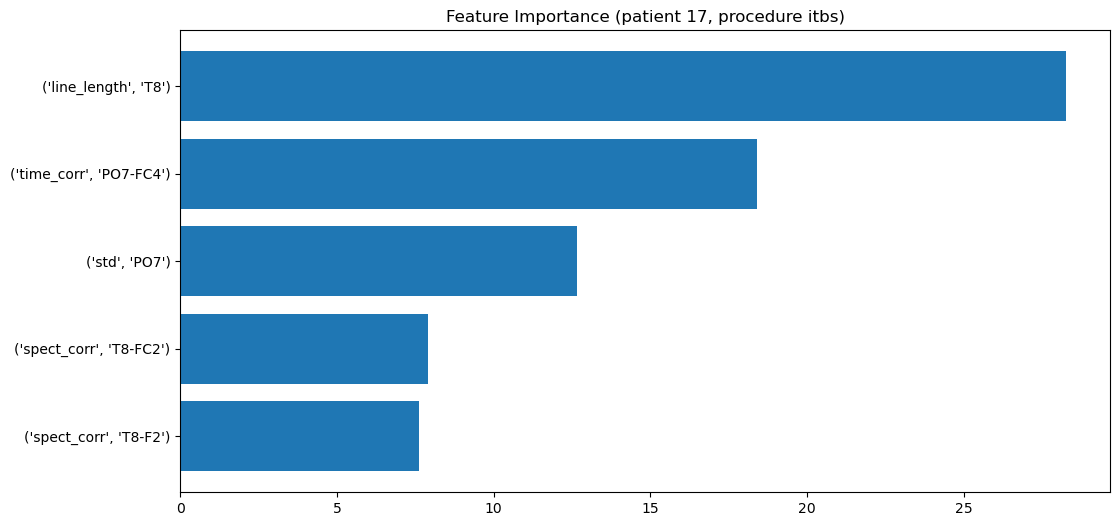

[2024-07-19 17:40:53,502] - INFO - Training model for patient 17 and procedure ctbs


Original DataFrame shape: (407, 6913)
Filtered DataFrame shape: (407, 6913)
Accuracy on test set:  1.0


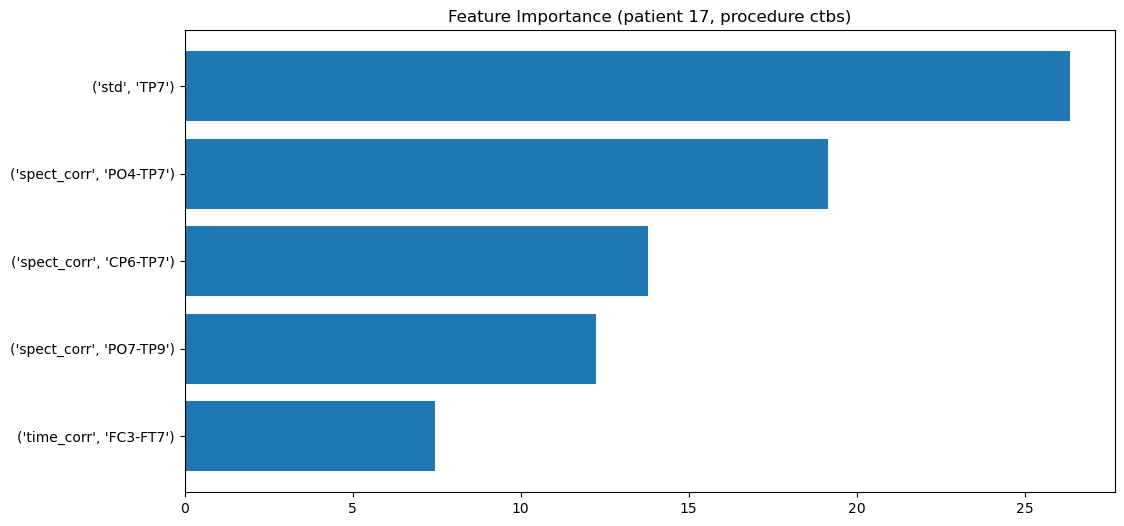

[2024-07-19 17:41:03,124] - INFO - Training model for patient 16 and procedure sham


Original DataFrame shape: (198, 6913)
Filtered DataFrame shape: (198, 6913)


CatBoostError: /src/catboost/catboost/private/libs/target/target_converter.cpp:404: Target contains only one unique value

In [10]:
# loop over all unique values in the "patient_id" column of the labels_df
patient_ids = labels_df["patient_id"].unique()

# first paradigm
for patient_id in patient_ids:
    for procedure in ["sham", "itbs", "ctbs"]:
        # make dataframe of all files for this patient and procedure
        files = labels_df[(labels_df["patient_id"] == patient_id) & (labels_df["procedure"] == procedure)]["filename"]
        # get data and labels
        data = get_data("features-4", files)
        labels = get_labels("pre_post", labels_df, files)
        
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
        
        train_data_df = X_train
        train_labels_df = y_train
        test_data_df = X_test
        test_labels_df = y_test
        
        # data prep
        train_data_df_clean, train_labels_df_clean, test_data_df_clean = data_prep(train_data_df, train_labels_df, test_data_df)
        
        # training
        logger.info(f"Training model for patient {patient_id} and procedure {procedure}")
        model = train_catboost(train_data_df_clean, train_labels_df_clean, test_data_df_clean, test_labels_df)

        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)[-5:]
        fig = plt.figure(figsize=(12, 6))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
        plt.title(f'Feature Importance (patient {patient_id}, procedure {procedure})')
        plt.show()

# second paradigm
for patient_id in patient_ids:
    # make dataframe of all files for this patient
    files = labels_df[(labels_df["patient_id"] == patient_id) & (labels_df["pre_post"] == "post")]["filename"]
    
    data = get_data("features-4", files)
    labels = get_labels("procedure", labels_df, files)
        
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
        
    train_data_df = X_train
    train_labels_df = y_train
    test_data_df = X_test
    test_labels_df = y_test
        
    # data prep
    train_data_df_clean, train_labels_df_clean, test_data_df_clean = data_prep(train_data_df, train_labels_df, test_data_df)
        
    # training
    logger.info(f"Training post procedure model for patient {patient_id}")
    model = train_catboost(train_data_df_clean, train_labels_df_clean, test_data_df_clean, test_labels_df, loss_function="MultiClass")

    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[-5:]
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.title(f'Feature Importance (patient {patient_id})')
    plt.show()

As expected based on the clustering, these paradigms are perfectly predictable for the machine learning model. This doesn't extend to other patients however, so it's of little use.